# Гипотеза
Добавление энтропии х как признака в данных улучшит качество модели. Текущее лучшее значение метрики: f1 =  0.8072364316905803

# Результат
Гипотеза успешна. model2 f1 entropy =  0.8080996884735203

# Refs
- [EDA](https://www.kaggle.com/maximmezhov/cardiospike-eda)
- [тетрадка с проверкой гипотезы-2](https://www.kaggle.com/maximmezhov/cardispike-hypothesis-2)

In [2]:
import pandas as pd
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import f1_score

In [3]:
# Const
RANDOM_STATE = 0

# Полезные методы

In [4]:
def make_XY(df):
    """
    df: dataset
    return:
    X: numpy array with features, values are scaled
    y: numpy array of target labels
    """
    X = df.drop(['y','id','time'], axis=1).to_numpy()
    y = df.y.to_numpy()

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
        
    print('scaler.pkl was saved in output directory')

    return X, y


def get_train_test_indexes(X,y):
    """
    X,y: numpy arrays with features and target
    return stratified indexes:
        train_indexes: indexes for train data
        test_indexes: indexes for test data
    """
    skf = StratifiedKFold()
    folds = dict()
    for i, (train_indexes, test_indexes) in enumerate(skf.split(X,y)):
        folds[i] = {
            'train_indexes': train_indexes,
            'test_indexes': test_indexes
        }
    return folds[0]['train_indexes'].tolist(), folds[0]['test_indexes'].tolist()

In [5]:
from scipy.stats import entropy

def entropy1(labels, base=None):
    _, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=base)

# Подготовка датасета

In [10]:
df = pd.read_csv('data/train.csv')
ids = df.id.unique()
for rr_id in ids:
    mask = (df.id==rr_id)
    df.loc[mask, 'entropy'] = df[mask].x.rolling(20).apply(entropy1).fillna(method='bfill')
    df.loc[mask, 'x_diff'] = df[mask].x.diff()
    df.loc[mask, 'x_deviation_median'] = df[mask].x.median() - df[mask].x.values
    for i in range(1,5):
        # добавим в признаки 4 следующие точки
        df.loc[mask, f'x+{i}'] = df[mask].x.shift(-i)
        # и 4 предыдущие точки
        df.loc[mask, f'x-{i}'] = df[mask].x.shift(i)
    df.loc[mask, 'x-(x+1)'] = df[mask].x.values - df.loc[mask, 'x+1'].values
#     df.loc[mask, 'x-(x-1)'] = df[mask].x.values - df.loc[mask, 'x-1'].values  # feature_importance = 0
    df.loc[mask, 'x-(x+2)'] = df[mask].x.values - df.loc[mask, 'x+2'].values
    df.loc[mask, 'x-(x-2)'] = df[mask].x.values - df.loc[mask, 'x-2'].values
    df.loc[mask, 'x-(x+3)'] = df[mask].x.values - df.loc[mask, 'x+3'].values
    df.loc[mask, 'x-(x-3)'] = df[mask].x.values - df.loc[mask, 'x-3'].values
    df.loc[mask, 'x-(x+4)'] = df[mask].x.values - df.loc[mask, 'x+4'].values
    df.loc[mask, 'x-(x-4)'] = df[mask].x.values - df.loc[mask, 'x-4'].values

In [8]:
print('TEST')
print('- всего ритмограмм в наборе данных', len(df.id.unique()), 'штук\n')
print('- в каждой ритмограмме первые и последние 4 строки \n' \
       'будут с пропусками из-за отсутствия данных о прошлых и будущих точках для \n' \
      'первых и последних 4 точек в радиограмме,\n' \
      'следовательно строк с пропусками должно быть', len(df.id.unique())*8, '\n')
print('- финальный размер датасета должне быть', len(df)-len(df.id.unique())*8, '\n')

print('смотрим, что получается по факту:')
print('df', len(df))
print('df.dropna', len(df.dropna()))
print('разница', len(df) - len(df.dropna()))
if (len(df)-len(df.id.unique())*8 == len(df.dropna())):
    print('Итог: по размеру датасет соответствует ожидаемому, ' \
          'нужно ещё выбрать контрольный пример для оценки глазами')
    print(':)')
else:
    print('Итог: по размерности не сходится... ' \
          'надо проверить алгоритм добавления признаков')
    print(':(')

TEST
- всего ритмограмм в наборе данных 229 штук

- в каждой ритмограмме первые и последние 4 строки 
будут с пропусками из-за отсутствия данных о прошлых и будущих точках для 
первых и последних 4 точек в радиограмме,
следовательно строк с пропусками должно быть 1832 

- финальный размер датасета должне быть 58655 

смотрим, что получается по факту:
df 60487
df.dropna 58655
разница 1832
Итог: по размеру датасет соответствует ожидаемому, нужно ещё выбрать контрольный пример для оценки глазами
:)


In [9]:
# контрольный пример для оценки глазами
mask = (df.id==13)
display(df[mask].head(10))
display(df[mask].tail(10))

,id,time,x,y,entropy,x_diff,x_deviation_median,x+1,x-1,x+2,...,x-3,x+4,x-4,x-(x+1),x-(x+2),x-(x-2),x-(x+3),x-(x-3),x-(x+4),x-(x-4)
3108,13,0,632,0,2.359266,NaN,-16.0,464.0,NaN,160.0,...,NaN,404.0,NaN,168.0,472.0,NaN,-208.0,NaN,228.0,NaN
3109,13,464,464,0,2.359266,-168.0,152.0,160.0,632.0,840.0,...,NaN,1260.0,NaN,304.0,-376.0,NaN,60.0,NaN,-796.0,NaN
3110,13,624,160,0,2.359266,-304.0,456.0,840.0,464.0,404.0,...,NaN,676.0,NaN,-680.0,-244.0,-472.0,-1100.0,NaN,-516.0,NaN
3111,13,1464,840,0,2.359266,680.0,-224.0,404.0,160.0,1260.0,...,632.0,572.0,NaN,436.0,-420.0,376.0,164.0,208.0,268.0,NaN
3112,13,1868,404,0,2.359266,-436.0,212.0,1260.0,840.0,676.0,...,464.0,628.0,632.0,-856.0,-272.0,244.0,-168.0,-60.0,-224.0,-228.0
3113,13,3128,1260,0,2.359266,856.0,-644.0,676.0,404.0,572.0,...,160.0,628.0,464.0,584.0,688.0,420.0,632.0,1100.0,632.0,796.0
3114,13,3804,676,0,2.359266,-584.0,-60.0,572.0,1260.0,628.0,...,840.0,636.0,160.0,104.0,48.0,272.0,48.0,-164.0,40.0,516.0
3115,13,4376,572,0,2.359266,-104.0,44.0,628.0,676.0,628.0,...,404.0,628.0,840.0,-56.0,-56.0,-688.0,-64.0,168.0,-56.0,-268.0
3116,13,5004,628,0,2.359266,56.0,-12.0,628.0,572.0,636.0,...,1260.0,680.0,404.0,0.0,-8.0,-48.0,0.0,-632.0,-52.0,224.0
3117,13,5632,628,1,2.359266,0.0,-12.0,636.0,628.0,628.0,...,676.0,584.0,1260.0,-8.0,0.0,56.0,-52.0,-48.0,44.0,-632.0


,id,time,x,y,entropy,x_diff,x_deviation_median,x+1,x-1,x+2,...,x-3,x+4,x-4,x-(x+1),x-(x+2),x-(x-2),x-(x+3),x-(x-3),x-(x+4),x-(x-4)
3362,13,144540,396,0,2.316114,-228.0,220.0,216.0,624.0,624.0,...,364.0,508.0,256.0,180.0,-228.0,-224.0,236.0,32.0,-112.0,140.0
3363,13,144756,216,0,2.316114,-180.0,400.0,624.0,396.0,160.0,...,620.0,576.0,364.0,-408.0,56.0,-408.0,-292.0,-404.0,-360.0,-148.0
3364,13,145380,624,0,2.191013,408.0,-8.0,160.0,216.0,508.0,...,624.0,616.0,620.0,464.0,116.0,228.0,48.0,0.0,8.0,4.0
3365,13,145540,160,0,2.316114,-464.0,456.0,508.0,624.0,576.0,...,396.0,468.0,624.0,-348.0,-416.0,-56.0,-456.0,-236.0,-308.0,-464.0
3366,13,146048,508,0,2.441215,348.0,108.0,576.0,160.0,616.0,...,216.0,440.0,396.0,-68.0,-108.0,-116.0,40.0,292.0,68.0,112.0
3367,13,146624,576,0,2.553682,68.0,40.0,616.0,508.0,468.0,...,624.0,848.0,216.0,-40.0,108.0,416.0,136.0,-48.0,-272.0,360.0
3368,13,147240,616,0,2.553682,40.0,0.0,468.0,576.0,440.0,...,160.0,NaN,624.0,148.0,176.0,108.0,-232.0,456.0,NaN,-8.0
3369,13,147708,468,0,2.553682,-148.0,148.0,440.0,616.0,848.0,...,508.0,NaN,160.0,28.0,-380.0,-108.0,NaN,-40.0,NaN,308.0
3370,13,148148,440,0,2.649159,-28.0,176.0,848.0,468.0,NaN,...,576.0,NaN,508.0,-408.0,NaN,-176.0,NaN,-136.0,NaN,-68.0
3371,13,148996,848,0,2.649159,408.0,-232.0,NaN,440.0,NaN,...,616.0,NaN,576.0,NaN,NaN,380.0,NaN,232.0,NaN,272.0


> всё в порядке

In [11]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58655 entries, 4 to 60482
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  58655 non-null  int64  
 1   time                58655 non-null  int64  
 2   x                   58655 non-null  int64  
 3   y                   58655 non-null  int64  
 4   entropy             58655 non-null  float64
 5   x_diff              58655 non-null  float64
 6   x_deviation_median  58655 non-null  float64
 7   x+1                 58655 non-null  float64
 8   x-1                 58655 non-null  float64
 9   x+2                 58655 non-null  float64
 10  x-2                 58655 non-null  float64
 11  x+3                 58655 non-null  float64
 12  x-3                 58655 non-null  float64
 13  x+4                 58655 non-null  float64
 14  x-4                 58655 non-null  float64
 15  x-(x+1)             58655 non-null  float64
 16  x-(x

In [8]:
# сохраним датасет в с текущими признаками, предварительно удалив строки с пропусками
with open('dataset.pkl', 'wb') as f:
    pickle.dump(df, f)
    
df.to_csv('dataset.csv')

# X, y

In [12]:
# make X and y
X,y = make_XY(df)

# make train and test datasets
train_indexes, test_indexes = get_train_test_indexes(X,y)
X_train = X[train_indexes]
X_test = X[test_indexes]
y_train = y[train_indexes]
y_test = y[test_indexes]

print('train', X_train.shape, y_train.shape)
print('test', X_test.shape, y_test.shape)

scaler.pkl was saved in output directory
train (46924, 19) (46924,)
test (11731, 19) (11731,)


# Обучение и оценка

##### cardiospike-pipeline:
f1_micro = 0.9473190691330662
f1_binary = 0.8072364316905803
##### entropy added:
f1_binary = 0.8079925070246644

f1_micro = 0.9473190691330662
f1_binary = 0.8079925070246644


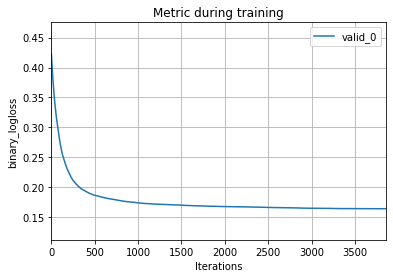

In [13]:
model = lgb.LGBMClassifier(n_estimators=3860, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1)
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model);

print('f1_micro =', 0.9473190691330662)
print('f1_binary =', f1_score(y_test, model.predict(X_test)))

попробуем параметры из [baseline-tuning](https://www.kaggle.com/maximmezhov/cardiospike-baseline-tuning#model-v3---best)

f1_micro = 0.9473190691330662
model f1 =  0.8072364316905803
model2 f1 entropy =  0.8080996884735203
model2 f1 = 0.8012558869701726


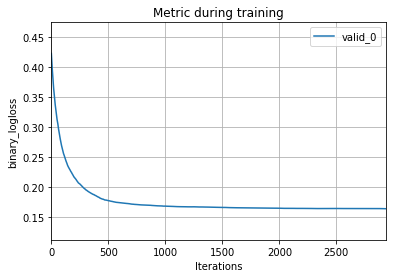

In [17]:
model2 = lgb.LGBMClassifier(n_estimators=2937, learning_rate=0.01, random_state=RANDOM_STATE, n_jobs=-1, 
                            max_depth=14, num_leaves=50)
model2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
lgb.plot_metric(model2);

print('f1_micro =', 0.9473190691330662)
print('model f1 = ', 0.8072364316905803)
print('model2 f1 entropy = ',  f1_score(y_test, model2.predict(X_test)))
print('model2 f1 =', 0.8012558869701726)

> стало похуже

# Значимость признаков

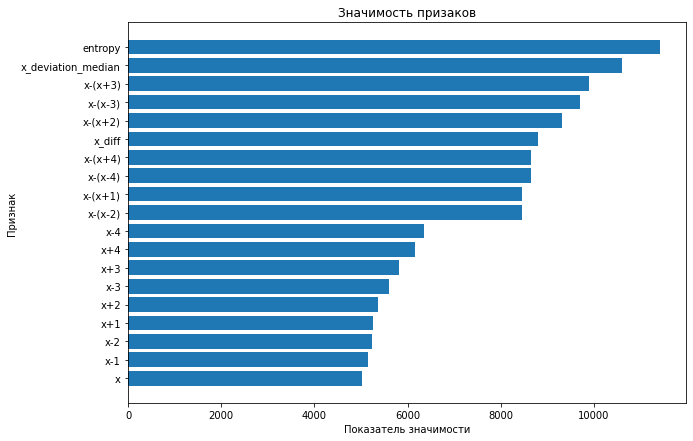

In [16]:
importance = model2.feature_importances_
features = df.drop(['y','id','time'],axis=1).columns

sorted_indexes = np.argsort(importance)
fig = plt.figure(figsize=(10,7))
plt.barh(y=features[sorted_indexes], width=importance[sorted_indexes])
plt.title('Значимость призаков')
plt.xlabel('Показатель значимости')
plt.ylabel('Признак')
plt.show()